In [1]:
! pip install pytorch-lightning -q
! pip list | grep torch
! nvidia-smi

     |████████████████████████████████| 585 kB 4.9 MB/s 
     |████████████████████████████████| 140 kB 74.7 MB/s 
     |████████████████████████████████| 596 kB 58.4 MB/s 
     |████████████████████████████████| 419 kB 68.7 MB/s 
     |████████████████████████████████| 1.1 MB 54.4 MB/s 
     |████████████████████████████████| 271 kB 66.5 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 144 kB 74.4 MB/s 
pytorch-lightning             1.6.4
torch                         1.11.0+cu113
torchaudio                    0.11.0+cu113
torchmetrics                  0.9.1
torchsummary                  1.5.1
torchtext                     0.12.0
torchvision                   0.12.0+cu113
Mon Jun 13 09:28:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+-----------------

In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#코랩 구글마운트 인증키 넣어서 해결해보기

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME ='엘리스_AI프로젝트 '
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/Shareddrives/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/Shareddrives/$FOLDERNAME

Mounted at /content/drive
[Errno 2] No such file or directory: 'drive/Shareddrives/엘리스_AI프로젝트'
/content


In [3]:
import random
import torch
def seed_everything(seed=7):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']= str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False

오피스 아워 : 3번째 셀은 되는데 2번째 셀은 왜....?ㅠㅠ

In [4]:
%matplotlib inline

import os
import json
import pandas as pd
from pprint import pprint

base_path = '/content/drive/Shareddrives/엘리스_AI프로젝트 /'
path_csv = os.path.join(base_path, 'train.csv')
train_data = pd.read_csv(path_csv)
test_data=pd.read_csv(os.path.join(base_path, 'test_csv.csv'))

In [5]:
import numpy as np

train_data['nb_classes'] = [len(lbs.split(" ")) for lbs in train_data['labels']]
lb_hist = dict(zip(range(10), np.bincount(train_data['nb_classes'])))
print(lb_hist)

{0: 0, 1: 17277, 2: 1155, 3: 200}


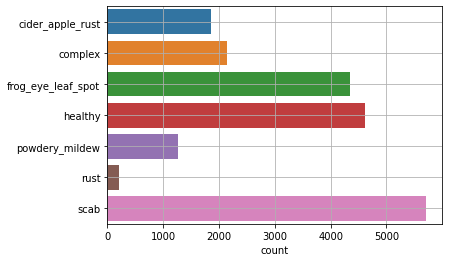

In [6]:
import itertools
import seaborn as sns

labels_all = list(itertools.chain(*[lbs.split(" ") for lbs in train_data['labels']]))
ax = sns.countplot(y=sorted(labels_all), orient='v')
ax.grid()

In [7]:
labels_unique=sorted(labels_all)
{lb: i for i, lb in enumerate(labels_unique)}

{'cider_apple_rust': 1859,
 'complex': 4010,
 'frog_eye_leaf_spot': 8362,
 'healthy': 12986,
 'powdery_mildew': 14257,
 'rust': 14474,
 'scab': 20186}

In [8]:
data= pd.read_csv(os.path.join(base_path, 'data.csv'))
data = data.sample(frac=1).reset_index(drop=True)
data.head(10)

,Unnamed: 0,image,labels,nb_classes
0,613,84713e23c0d37b6e.jpg,healthy,1
1,10788,cac6ea04884cff7c.jpg,scab,1
2,7421,b4e4c31a50fb59c5.jpg,scab,3
3,14334,e499777833c11366.jpg,healthy,1
4,680,84d7fe5c7c0c43c2.jpg,cider_apple_rust,1
5,17079,f780819c8e6f3473.jpg,frog_eye_leaf_spot,1
6,14836,e8b3d3d69a968494.jpg,frog_eye_leaf_spot,1
7,9784,c3b3d7904a783707.jpg,frog_eye_leaf_spot,3
8,8356,bbe2c9e04993f01d.jpg,powdery_mildew,1
9,13527,df7240d2af908755.jpg,scab,1


**< imbalance data를 해결하는 방법 >**

1. oversampling 
장점 : under-sampling보다 성능이 뛰어나다. 
단점 : minor class를 판별시 과적합 될 가능성이 있다.

2. undersampling
장점 :  모델이 빨리 돌아간다.
단점 : 과적합

3. SMOTE : 주변에 있는 데이터셋의 특징과 유사하게 데이터를 생성한다.
장점 : 데이터 손실을 하지 않으면서 과적합을 피할 수 있다.
단점 : 고차원 데이터에 효율적이지 않다.

우리는 고차원 데이터를 다루고 있기때문에 oversampling을 쓸 것이다.

**< Pytorch 에서는 어떻게 ? >** 

파이토치에서 sampler 옵션을 사용하면 데이터 크래스와 상호 작용하고 이 클래스에서 샘플링 하는 방법을 알려준다.
다른 클래스의 가중치를 사용하여 sampler 클래스 객체를 생성하는 방식이다.

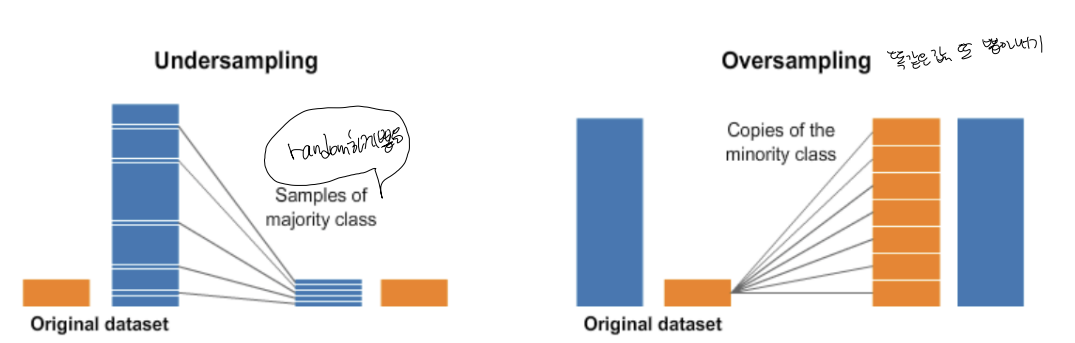

**< 주의할 점! >**

반드시 cross-validation을 한 후에 데이터를 증강시킨다.
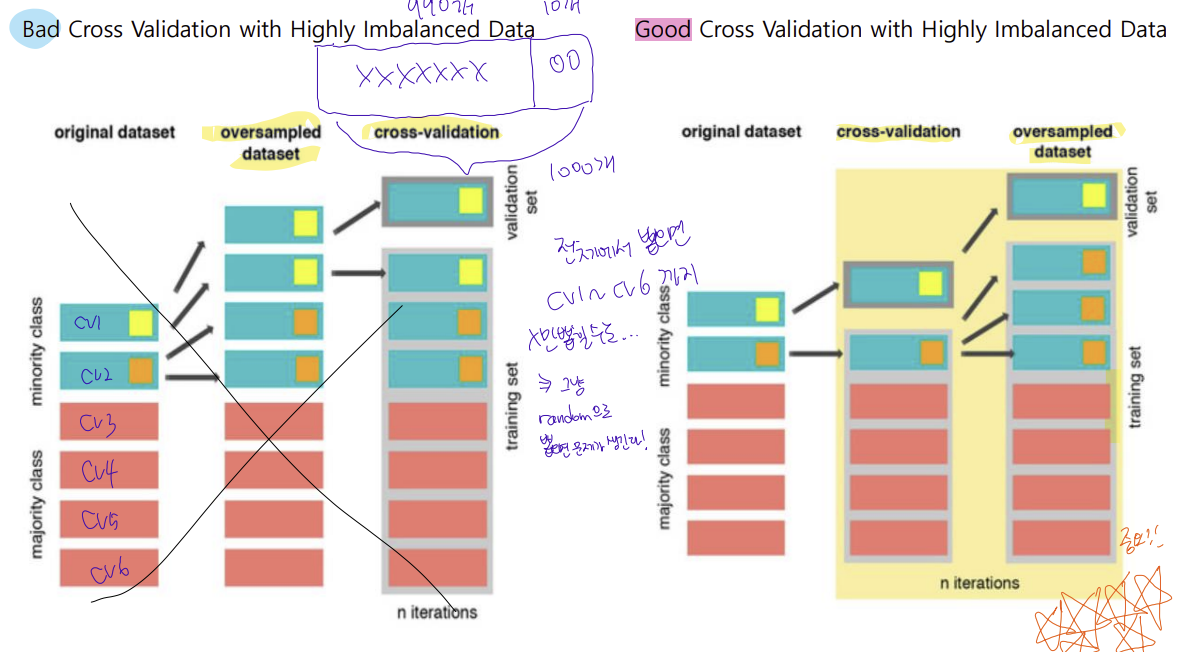

In [9]:
# labels_unique = set(labels_all)
# print(f"unique labels: {labels_unique}")
# train_data['labels_sorted'] = [" ".join(sorted(lbs.split(" "))) for lbs in train_data['labels']]

# labels_combine = {}
# for comb in train_data['labels_sorted']:
#     labels_combine[comb] = labels_combine.get(comb, 0) + 1

# show_counts = '\n'.join(sorted(f'\t{k}: {v}' for k, v in labels_combine.items()))
# print(f"unique combinations: \n" + show_counts)
# print(f"total: {sum(labels_combine.values())}")

(-0.5, 959.5, 640.5, -0.5)

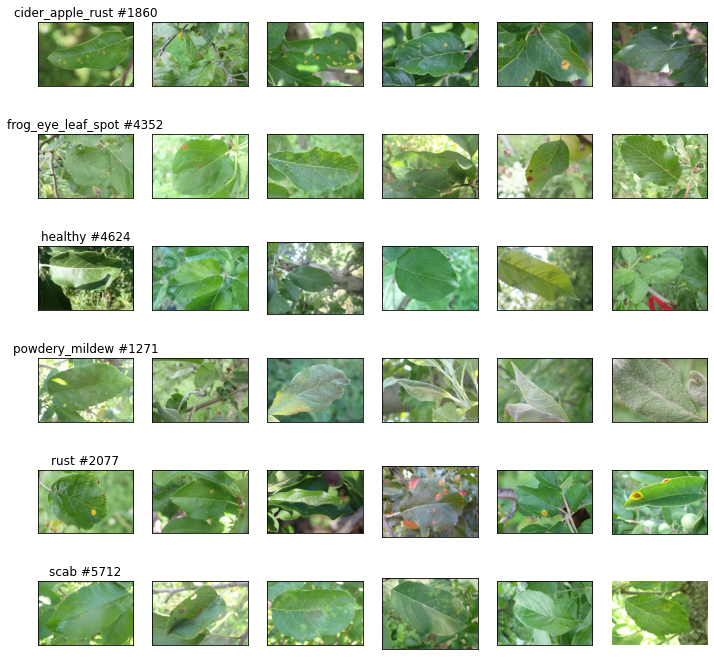

In [10]:
import matplotlib.pyplot as plt

nb_samples = 6
n, m = len(np.unique(data['labels'])), nb_samples,
fig, axarr = plt.subplots(nrows=n, ncols=m, figsize=(m * 2, n * 2))
for ilb, (lb, df_) in enumerate(data.groupby('labels')):
    img_names = list(df_['image'])
    for i in range(m):
        img_name = img_names[i]
        img = plt.imread(os.path.join(base_path, f"train_images/{img_name}"))
        axarr[ilb, i].imshow(img)
        if i == 0:
            axarr[ilb, i].set_title(f"{lb} #{len(df_)}")
        axarr[ilb, i].set_xticks([])
        axarr[ilb, i].set_yticks([])
plt.axis('off')

데이터셋 준비!

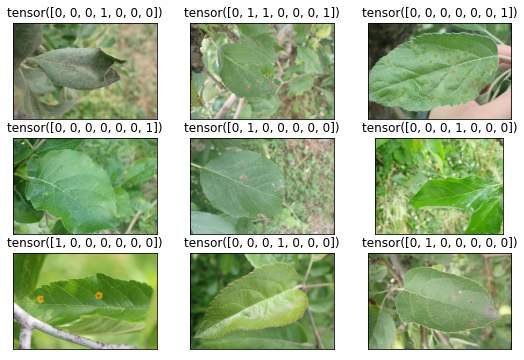

In [11]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset

class PlantPathologyDataset(Dataset):
    def __init__(
        self,
        path_csv: str = os.path.join(base_path, 'train.csv'),
        path_img_dir: str = os.path.join(base_path, 'train_images'),
        transforms = None,
        mode: str = 'train',
        split: float = 0.8,
    ):
        self.path_img_dir = path_img_dir
        self.transforms = transforms
        self.mode = mode

        self.data = pd.read_csv(path_csv)
        labels_all = list(itertools.chain(*[lbs.split(" ") for lbs in self.data['labels']]))
        self.labels_unique = sorted(set(labels_all))
        self.labels_lut = {lb: i for i, lb in enumerate(self.labels_unique)}
        self.num_classes = len(self.labels_unique)

        # split dataset
        assert 0.0 <= split <= 1.0
        frac = int(split * len(self.data))
        self.data = self.data[:frac] if mode == 'train' else self.data[frac:]
        self.img_names = list(self.data['image'])
        self.labels = list(self.data['labels'])

    def to_one_hot(self, labels: str) -> tuple:
        one_hot = [0] * len(self.labels_unique)
        for lb in labels.split(" "):
            one_hot[self.labels_lut[lb]] = 1
        return tuple(one_hot)

    def __getitem__(self, idx: int) -> tuple:
        img_path = os.path.join(self.path_img_dir, self.img_names[idx])
        assert os.path.isfile(img_path)
        label = self.labels[idx]
        img = plt.imread(img_path)

        # augmentation
        if self.transforms:
            img = self.transforms(Image.fromarray(img))
        label = self.to_one_hot(label)
        return img, torch.tensor(label)

    def __len__(self) -> int:
        return len(self.data)

# ==============================
# ==============================

dataset = PlantPathologyDataset()

# quick view
fig = plt.figure(figsize=(9, 6))
for i in range(9):
    img, lb = dataset[i]
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(lb)

In [12]:
from torchvision import transforms as T
TRAIN_TRANSFORM = T.Compose([
    T.Resize(512),
    T.RandomPerspective(),
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # T.Normalize([0.431, 0.498,  0.313], [0.237, 0.239, 0.227]),  # custom
])

VALID_TRANSFORM = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # T.Normalize([0.431, 0.498,  0.313], [0.237, 0.239, 0.227]),  # custom
])

In [13]:
import torch
import torch.utils.data
import torchvision


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.labels[idx]
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

training dataset: 14905
test dataset: 3727
7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch labels: tensor([12, 16, 31, 29,  9,  0, 45])
image size: torch.Size([3, 224, 224])


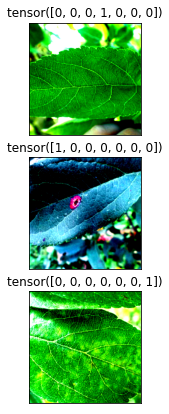

In [14]:
import multiprocessing as mproc
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class PlantPathologyDM(pl.LightningDataModule):
    dataset_cls = PlantPathologyDataset

    def __init__(
        self,
        path_csv: str = os.path.join(base_path, 'train.csv'),
        path_img_dir: str = os.path.join(base_path, 'train_images'),
        batch_size: int = 128,
        num_workers: int = None,
    ):
        super().__init__()
        self.path_csv = path_csv
        self.path_img_dir = path_img_dir
        self.batch_size = batch_size
        self.num_workers = num_workers if num_workers is not None else mproc.cpu_count()
        self.train_dataset = None
        self.test_dataset = None

    def prepare_data(self):
        pass

    @property
    def num_classes(self) -> int:
        assert self.train_dataset and self.test_dataset
        return max(self.train_dataset.num_classes, self.test_dataset.num_classes)

    def setup(self, stage=None):
        self.train_dataset = self.dataset_cls(self.path_csv, self.path_img_dir, mode='train', transforms=TRAIN_TRANSFORM)
        print(f"training dataset: {len(self.train_dataset)}")
        self.test_dataset = self.dataset_cls(self.path_csv, self.path_img_dir, mode='test', transforms=VALID_TRANSFORM)
        print(f"test dataset: {len(self.test_dataset)}")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )


    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

# ==============================
# ==============================

dm = PlantPathologyDM()
dm.setup()
print(dm.num_classes)

# quick view
fig = plt.figure(figsize=(3, 7))
for imgs, lbs in dm.test_dataloader():
    print(f'batch labels: {torch.sum(lbs, axis=0)}')
    print(f'image size: {imgs[0].shape}')
    for i in range(3):
        ax = fig.add_subplot(3, 1, i + 1, xticks=[], yticks=[])
        # print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
        ax.set_title(lbs[i])
    break

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [16]:
#Stratified K-fold 교차 검증방법
from sklearn.model_selection import StratifiedKFold
n_iter=0
skf = StratifiedKFold(n_splits=5)

##CNN Model

In [17]:
import torch
import torchmetrics
import torchvision
from torch import nn
from torch.nn import functional as F


class LitResnet(nn.Module):
    def __init__(self, arch: str, pretrained: bool = True, num_classes: int = 6):
        super().__init__()
        self.arch = arch
        self.num_classes = num_classes
        self.model = torchvision.models.__dict__[arch](pretrained=pretrained)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.model(x)


class LitPlantPathology(pl.LightningModule):

    def __init__(self, model, lr: float = 1e-4):
        super().__init__()
        self.model = model
        self.arch = self.model.arch
        self.num_classes = self.model.num_classes
        self.train_accuracy = torchmetrics.Accuracy()
        self.val_accuracy = torchmetrics.Accuracy()
        self.val_f1_score = torchmetrics.F1Score(self.num_classes)
        self.learn_rate = lr
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return F.sigmoid(self.model(x))

    def compute_loss(self, y_hat, y):
        return self.loss(y_hat, y.to(float))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", self.train_accuracy(y_hat, y), prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.log("valid_loss", loss, prog_bar=False)
        self.log("valid_acc", self.val_accuracy(y_hat, y), prog_bar=True)
        self.log("valid_f1", self.val_f1_score(y_hat, y), prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learn_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.trainer.max_epochs, 0)
        return [optimizer], [scheduler]

# ==============================
# ==============================

# see: https://pytorch.org/vision/stable/models.html
net = LitResnet(arch='resnet50', num_classes=dm.num_classes).to(device)
# print(net)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [28]:
num_epochs=10
batch_size=128
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        output= output[:-1]
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

In [29]:
import torch.nn as nn
foldperf={}
from torch.utils.data import SubsetRandomSampler
criterion = nn.CrossEntropyLoss()
for fold, (train_idx,val_idx) in enumerate(skf.split(train_data[:14905]['image'], train_data[:14905]['labels'])):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(PlantPathologyDataset(mode='train', transforms=TRAIN_TRANSFORM), batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(PlantPathologyDataset(mode='train', transforms=TRAIN_TRANSFORM), batch_size=batch_size, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = LitPlantPathology(model=net)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history  

torch.save(model,'k_cross_CNN.pt')   

Fold 1


RuntimeError: ignored

In [ ]:
logger = pl.loggers.CSVLogger(save_dir='logs/', name=model.arch)
n_iter =0
# ==============================
swa = pl.callbacks.StochasticWeightAveraging(swa_epoch_start=0.6)
ckpt = pl.callbacks.ModelCheckpoint(
    monitor='valid_f1',
    save_top_k=1,
    save_last=True,
    # save_weights_only=True,
    filename='checkpoint/{epoch:02d}-{valid_acc:.4f}-{valid_f1:.4f}',
    # verbose=False,
    mode='max',
)
trainer = pl.Trainer(
    # fast_dev_run=True,
    gpus=1,
    # tpu_cores=8,
    callbacks=[ckpt,swa],
    logger=logger,
    max_epochs=8,
    precision=16,
    accumulate_grad_batches=8,
    val_check_interval=0.25,
    progress_bar_refresh_rate=1,
    weights_summary='top',
)

# ==============================

# trainer.tune(model, datamodule=dm)
trainer.fit(model=model, datamodule=dm)

In [ ]:
trainer.save_checkpoint('fold1.ckpt")

In [ ]:
# class MyLightningModule(LitPlantPathology):
#     def __init__(self, *args, **kwargs):
#         super().__init__()
#         self.save_hyperparameters()
checkpoint = torch.load(os.path.join(base_path, 'example.ckpt'))
#print(checkpoint['state_dict'])

In [ ]:
new_model = LitPlantPathology(model=net)
new_weights = new_model.state_dict()
old_weights = list(checkpoint['state_dict'].items())

i=0
for k, _ in new_weights.items():
    new_weights[k] = old_weights[i][1]
    i += 1

new_model.load_state_dict(new_weights)

In [ ]:
torch.save(new_model, f'./dummy_model.pt')

In [ ]:
model=torch.load('dummy_model.pt',map_location=device)

In [ ]:
labels_all=list(itertools.chain(*[lbs.split(" ") for lbs in train_data['labels']]))
labels_unique = sorted(set(labels_all))
labels_lut = {lb: i for i, lb in enumerate(labels_unique)}
num_classes = len(labels_unique)
categories=[k for k,v in labels_lut.items()]
labels_unique

In [ ]:
labels_lut.items()

In [ ]:
preds = []
dm.batch_size = 8
model.eval()
y_pred=[]
for imgs, names in dm.test_dataloader():
    with torch.no_grad():
        imgs=imgs.cuda()
        encode = model(imgs)
        print(encode)
#     print(np.round(encode.cpu().detach().numpy(), decimals=2))
#     print(len(dm.test_dataloader()))
#     def onehot_to_label(val): 
#       return [k for k,v in labels_lut.items() if v == np.argmax(val.cpu().detach().numpy())]
#     for be, name in zip(encode,np.argmax(names.numpy(),axis=1).reshape(-1,1) ):
#         lbs = onehot_to_label(be) #여기서 be는 encode 원소들 즉, 예측결과
#         preds.append(dict(image=name, labels=" ".join(lbs)))
#         y_pred.append(lbs[0])
#     break

# df_preds = pd.DataFrame(preds)
# print(df_preds.head())

In [ ]:
data = {'y_Actual':    list(dm.test_dataloader['labels'].values),
        'y_Predicted': y_pred,
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
print (df)

In [ ]:
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)